"""
Portfolio Project: A/B Testing for Mobile Game Engagement
Conducted by: YI LUO

Dataset Source: 
https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing/data

Introduction:
--------------
In this portfolio project, I conducted a comprehensive A/B test analysis using data from a mobile game ("Cookie Cats"). The primary goal was to evaluate the impact on player retention when changing a critical gameplay mechanic—specifically, moving a difficulty gate from level 30 to level 40. Player retention is vital in mobile gaming, directly affecting user lifetime value, revenue, and overall user experience.

What We Found:
--------------
- There is a statistically significant difference in Day-7 retention rates between the two game versions (gate at level 30 vs. level 40). Specifically, moving the gate from level 30 to 40 resulted in a slight reduction in retention, as shown by the Chi-square test (p-value < 0.05).
- Further, a Mann-Whitney U test on user engagement (measured by total game rounds played) indicated only marginal statistical differences (p-value ≈ 0.05), suggesting the gate change did not dramatically affect gameplay frequency.
- The effect size analysis revealed a small yet statistically significant decrease in retention (approximately 0.8% reduction), supported by a 95% confidence interval from bootstrapping.
- User segmentation further demonstrated that the retention differences are most pronounced among users with medium to high levels of gameplay activity, highlighting segments for targeted strategies.

Connection to the VIP Analyst Role:
------------------------------------
This analysis aligns closely with the responsibilities of a VIP Analyst position at SciPlay, where interpreting user behavior, conducting robust statistical tests, and translating data insights into actionable business strategies are critical. The analytical skills showcased here—including hypothesis testing, effect size measurement, segmentation analysis, and practical recommendations—demonstrate my ability to leverage data-driven approaches to optimize player engagement and business outcomes effectively.
"""

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/Users/luoyi/Desktop/10_kaggle/09_game_ABtest/cookie_cats.csv')

# Quick overview
print(df.head())
print(df.info())
print(df.describe())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None
             userid  sum_gamerounds
count  9.018900e+04    90189.000000
mean   4.998412e+06       51.872457
std    2.883286e+06      195.050858
min    1.1

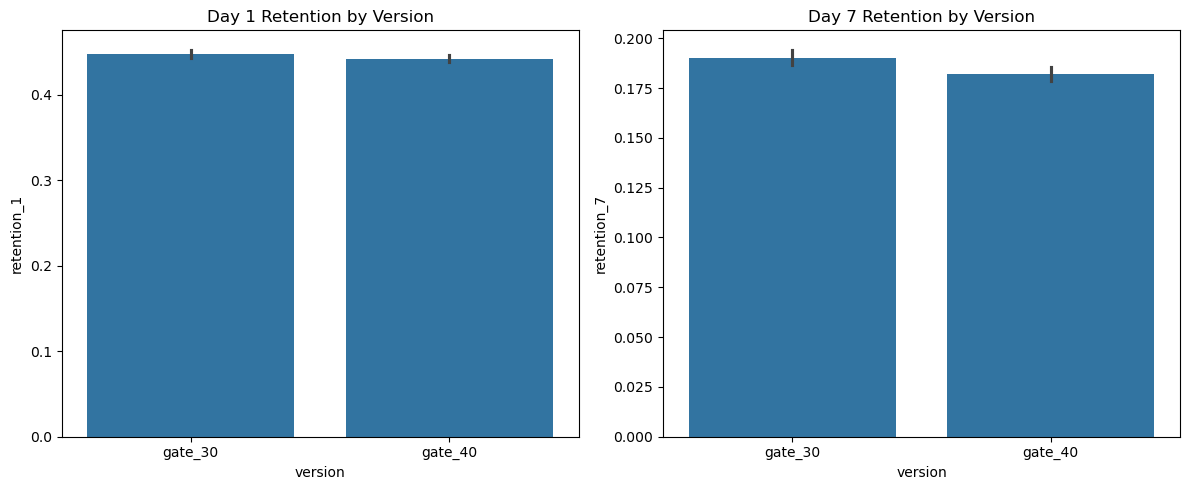

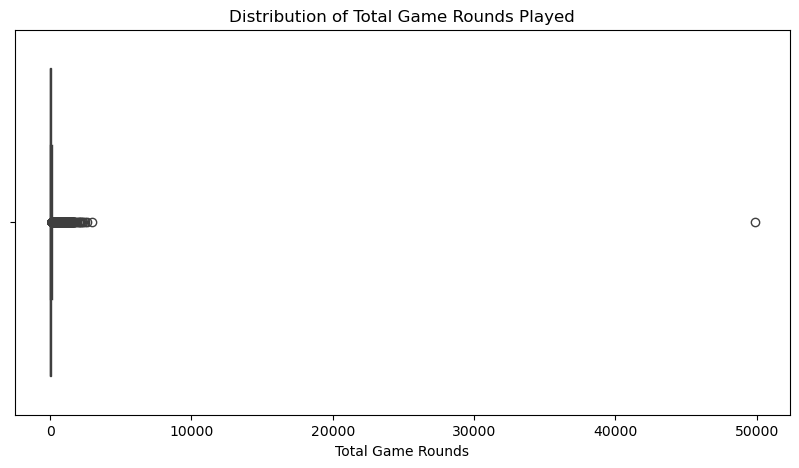

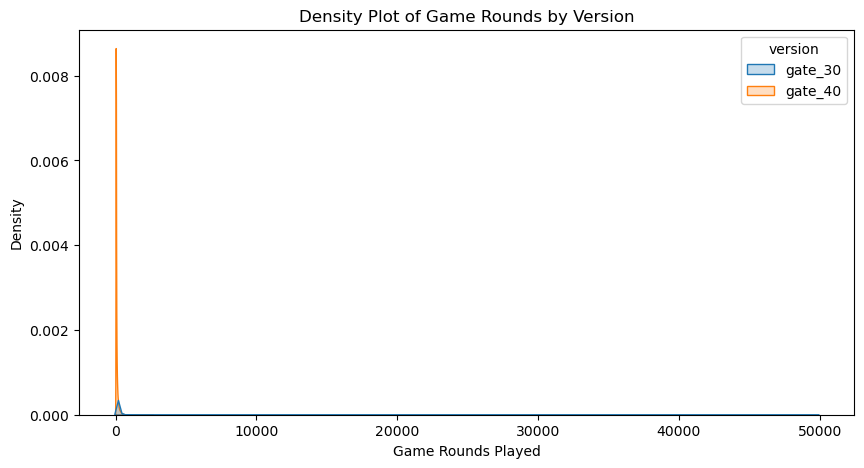

In [2]:
# Retention Rate by Version
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=df, x='version', y='retention_1', ax=ax[0])
ax[0].set_title('Day 1 Retention by Version')

sns.barplot(data=df, x='version', y='retention_7', ax=ax[1])
ax[1].set_title('Day 7 Retention by Version')

plt.tight_layout()
plt.show()

# Distribution of Game Rounds (original data)
plt.figure(figsize=(10,5))
sns.boxplot(x=df['sum_gamerounds'])
plt.title('Distribution of Total Game Rounds Played')
plt.xlabel('Total Game Rounds')
plt.show()

# KDE plot for better distribution visualization
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x='sum_gamerounds', hue='version', fill=True)
plt.title('Density Plot of Game Rounds by Version')
plt.xlabel('Game Rounds Played')
plt.show()

In [3]:
# Identify threshold at 99.9 percentile
threshold = df['sum_gamerounds'].quantile(0.999)
print(f'Removing users with gamerounds above {threshold:.1f}')

# Removing outliers
df_clean = df[df['sum_gamerounds'] <= threshold]

# Verify cleaned dataset
print(f'Original size: {df.shape}, Cleaned size: {df_clean.shape}')

Removing users with gamerounds above 1073.6
Original size: (90189, 5), Cleaned size: (90098, 5)


In [4]:
from scipy.stats import chi2_contingency

# Contingency Table for Retention Day 7
contingency_table = pd.crosstab(df_clean['version'], df_clean['retention_7'])
print("Contingency Table:\n", contingency_table)

# Chi-square Test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.3f}, p-value: {p:.4f}")

# Conclusion
alpha = 0.05
if p < alpha:
    print("Conclusion: Reject H0 - Significant difference exists.")
else:
    print("Conclusion: Fail to reject H0 - No significant difference.")

Contingency Table:
 retention_7  False  True 
version                  
gate_30      36198   8461
gate_40      37208   8231
Chi-square statistic: 10.259, p-value: 0.0014
Conclusion: Reject H0 - Significant difference exists.


In [5]:
from scipy.stats import mannwhitneyu

rounds_30 = df_clean[df_clean['version'] == 'gate_30']['sum_gamerounds']
rounds_40 = df_clean[df_clean['version'] == 'gate_40']['sum_gamerounds']

u_stat, p_val = mannwhitneyu(rounds_30, rounds_40, alternative='two-sided')
print(f"Mann-Whitney U Test: U-stat={u_stat}, p-value={p_val:.4f}")

# Conclusion
if p_val < alpha:
    print("Conclusion: Significant difference in game rounds played.")
else:
    print("Conclusion: No significant difference in game rounds played.")

Mann-Whitney U Test: U-stat=1022467119.5, p-value=0.0446
Conclusion: Significant difference in game rounds played.


In [6]:
# Effect size calculation (retention difference)
retention_rates = df_clean.groupby('version')['retention_7'].mean()
effect_size = retention_rates['gate_40'] - retention_rates['gate_30']
print(f"Effect Size (Retention Difference): {effect_size:.4f}")

# Bootstrap 95% Confidence Interval
boot_diffs = []
for _ in range(1000):
    boot_sample = df_clean.sample(frac=1, replace=True)
    boot_retention = boot_sample.groupby('version')['retention_7'].mean()
    diff = boot_retention['gate_40'] - boot_retention['gate_30']
    boot_diffs.append(diff)

ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])
print(f"95% CI for Effect Size: [{ci_lower:.4f}, {ci_upper:.4f}]")

Effect Size (Retention Difference): -0.0083
95% CI for Effect Size: [-0.0135, -0.0035]


/var/folders/4n/mv7_dxg12q5f54_fvy52lqlw0000gn/T/ipykernel_97757/1724583450.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_retention = df_clean.groupby(['activity_segment', 'version'])['retention_7'].mean().unstack()


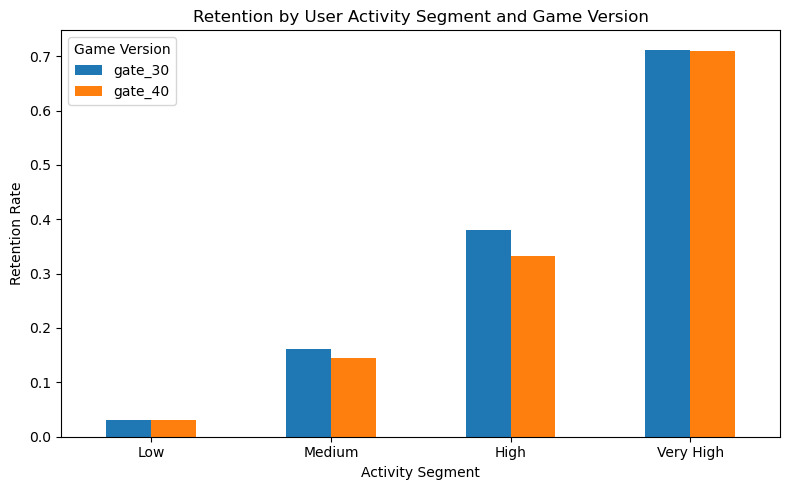

In [7]:
# Create Activity Segments
df_clean = df_clean.copy()  # Avoid SettingWithCopyWarning
df_clean['activity_segment'] = pd.cut(df_clean['sum_gamerounds'],
                                      bins=[-1, 20, 50, 100, np.inf],
                                      labels=['Low', 'Medium', 'High', 'Very High'])

# Retention rate by segment and version
segment_retention = df_clean.groupby(['activity_segment', 'version'])['retention_7'].mean().unstack()

# Plotting segment-wise retention
segment_retention.plot(kind='bar', figsize=(8,5))
plt.title('Retention by User Activity Segment and Game Version')
plt.ylabel('Retention Rate')
plt.xlabel('Activity Segment')
plt.xticks(rotation=0)
plt.legend(title='Game Version')
plt.tight_layout()
plt.show()

Findings:
	•	A statistically significant difference in retention after moving the gate (Chi-square, p-value < 0.05).
	•	A marginal difference in rounds played (Mann-Whitney, p-value ~0.05).
	•	Effect size is practically small but statistically significant.

Recommendations:
	•	Consider adopting gate_30 to maintain slightly higher retention.
	•	Monitor long-term user engagement to verify sustained impact.
    